# Insights de Performance em Marketing

Heatmap, Tendência Semanal e Pareto.

**Objetivo do projeto:** interpretar dados de desempenho para sugerir **otimizações contínuas** na estratégia de **canais** e **formatos**.

Você vai construir:
- Base sintética de campanhas (realista o suficiente para análise).
- KPIs (CTR, CPC, CPA, ROAS).
- Heatmap (Canal × Formato) para ROAS e CPA.
- Tendência semanal (ROAS e CPA).
- Pareto (80/20) de receita por combo.
- Recomendações automáticas (Escalar / Otimizar funil / Reduzir).


## 1) Setup e geração da base (sintética):

Aqui criamos uma base com colunas típicas de campanhas:
- `impressoes`, `cliques`, `custo`, `conversoes`, `receita`
- dimensões: `data`, `canal`, `formato`

A base é sintética (inventada), mas com regras que simulam padrões comuns:
- `Search` tende a converter melhor
- `Email` tende a ter CTR alto e custo baixo
- `Display` tende a CTR/conversão menores


In [6]:
# Importa bibliotecas numéricas e de dados.
import numpy as np              # NumPy: números aleatórios e operações numéricas.
import pandas as pd             # Pandas: tabelas (DataFrames) e agregações.
import matplotlib.pyplot as plt # Matplotlib: gráficos (vamos usar sem seaborn).
import os                       # OS: criar pastas e checar arquivos.
import shutil                   # Shutil: mover/copiar arquivos.
import zipfile                  # Zipfile: criar .zip para GitHub.

# Define uma semente (seed) para os números aleatórios.
# Isso faz o notebook gerar sempre os mesmos resultados (reprodutível).
np.random.seed(42)

# Cria um intervalo de datas (120 dias).
datas = pd.date_range("2025-09-01", periods=120, freq="D")

# Define os canais possíveis.
canais = [
    "Meta Ads",     # Meta (Facebook/Instagram).
    "Google Ads",   # Google Search/Display.
    "TikTok Ads",   # TikTok.
    "YouTube Ads",  # YouTube.
    "Email",        # E-mail marketing.
    "Orgânico"      # tráfego orgânico (sem custo).
]

# Define formatos (criativos ou tipos de mídia).
formatos = [
    "Reels",
    "Stories",
    "Feed",
    "Search",
    "Display",
    "Video Longo",
    "Newsletter"
]

# Define o tamanho da base (número de linhas).
n = 1800

# Monta um DataFrame com colunas dimensionais (data, canal, formato).
df = pd.DataFrame({
    "data": np.random.choice(datas, n),  # escolhe datas aleatórias.
    "canal": np.random.choice(           # escolhe canais com probabilidades.
        canais, n,
        p=[0.22, 0.23, 0.14, 0.12, 0.14, 0.15]
    ),
    "formato": np.random.choice(         # escolhe formatos com probabilidades.
        formatos, n,
        p=[0.17, 0.14, 0.14, 0.18, 0.14, 0.12, 0.11]
    ),
})

# Cria impressões com distribuição lognormal (muitos valores médios e alguns bem altos).
base_imps = np.random.lognormal(mean=9.0, sigma=0.55, size=n).astype(int)

# Atribui as impressões no DataFrame.
df["impressoes"] = base_imps

# Define CTR base por canal (tendências).
ctr_base = {
    "Meta Ads": 0.012,
    "Google Ads": 0.021,
    "TikTok Ads": 0.015,
    "YouTube Ads": 0.010,
    "Email": 0.045,
    "Orgânico": 0.018
}

# Define bônus/penalidade de CTR por formato (tendências).
ctr_bonus_formato = {
    "Reels": 0.004,
    "Stories": 0.002,
    "Feed": 0.001,
    "Search": 0.006,
    "Display": -0.003,
    "Video Longo": 0.000,
    "Newsletter": 0.010
}

# Calcula CTR final:
# 1) pega CTR base do canal.
# 2) soma bônus do formato.
# 3) adiciona ruído (variação aleatória) para simular instabilidade do mundo real.
ctr = (
    df["canal"].map(ctr_base) +
    df["formato"].map(ctr_bonus_formato) +
    np.random.normal(0, 0.002, n)
)

# Limita CTR para não ficar negativo nem absurdo.
ctr = np.clip(ctr, 0.002, 0.09)

# Calcula cliques = impressões * CTR.
df["cliques"] = (df["impressoes"] * ctr).astype(int)

# Define CPC base por canal (tendências).
cpc_base = {
    "Meta Ads": 1.60,
    "Google Ads": 2.40,
    "TikTok Ads": 1.30,
    "YouTube Ads": 1.90,
    "Email": 0.20,
    "Orgânico": 0.00
}

# Calcula CPC final com ruído.
cpc = df["canal"].map(cpc_base) + np.random.normal(0, 0.25, n)

# Garante que não existam CPCs negativos.
cpc = np.clip(cpc, 0, None)

# Calcula custo = cliques * CPC.
df["custo"] = (df["cliques"] * cpc).round(2)

# Define CVR (taxa de conversão) base por .
cvr_base_formato = {
    "Reels": 0.010,
    "Stories": 0.008,
    "Feed": 0.009,
    "Search": 0.025,
    "Display": 0.004,
    "Video Longo": 0.006,
    "Newsletter": 0.032
}

# Define bônus/penalidade de CVR por canal.
cvr_bonus_canal = {
    "Meta Ads": 0.001,
    "Google Ads": 0.004,
    "TikTok Ads": 0.000,
    "YouTube Ads": -0.001,
    "Email": 0.006,
    "Orgânico": 0.002
}

# Calcula CVR final com ruído.
cvr = (
    df["formato"].map(cvr_base_formato) +
    df["canal"].map(cvr_bonus_canal) +
    np.random.normal(0, 0.002, n)
)

# Limita CVR para intervalos realistas.
cvr = np.clip(cvr, 0.001, 0.12)

# Calcula conversões = cliques * CVR.
df["conversoes"] = (df["cliques"] * cvr).astype(int)

# Define ticket (valor médio por conversão) por canal.
ticket_base = {
    "Meta Ads": 120,
    "Google Ads": 160,
    "TikTok Ads": 110,
    "YouTube Ads": 140,
    "Email": 180,
    "Orgânico": 150
}

# Cria ticket com variação lognormal (simula variação de carrinho).
ticket = df["canal"].map(ticket_base) * np.random.lognormal(mean=0.0, sigma=0.15, size=n)

# Receita = conversões * ticket.
df["receita"] = (df["conversoes"] * ticket).round(2)

# Para tráfego orgânico, custo é zero (por definição).
df.loc[df["canal"] == "Orgânico", "custo"] = 0.0

# Converte data para datetime, ordena e reseta índice.
df["data"] = pd.to_datetime(df["data"])
df = df.sort_values("data").reset_index(drop=True)

# Mostra as primeiras linhas.
df.head()


,data,canal,formato,impressoes,cliques,custo,conversoes,receita
0,2025-09-01,YouTube Ads,Display,60580,639,1326.10,1,124.74
1,2025-09-01,Orgânico,Search,14238,338,0.00,8,1166.49
2,2025-09-01,TikTok Ads,Newsletter,16591,469,533.39,13,1596.35
3,2025-09-01,Google Ads,Search,6549,175,411.08,5,549.91
4,2025-09-01,Meta Ads,Display,8023,87,85.06,0,0.00


## 2) KPIs (CTR, CPC, CPA, ROAS):

Vamos criar funções seguras para evitar divisão por zero e calcular os KPIs principais:
- **CTR** = cliques / impressões
- **CPC** = custo / cliques
- **CPA** = custo / conversões
- **ROAS** = receita / custo


In [7]:
# Função auxiliar: divisão segura para evitar erros quando o denominador é 0.
def safe_div(a, b):
    # Converte para arrays float para garantir divisão correta.
    a = np.array(a, dtype=float)
    b = np.array(b, dtype=float)
    # Se b == 0, retorna 0; caso contrário, retorna a/b.
    return np.where(b == 0, 0, a / b)

# CTR: cliques / impressões.
df["ctr"] = safe_div(df["cliques"], df["impressoes"])

# CPC: custo / cliques.
df["cpc"] = safe_div(df["custo"], df["cliques"])

# CPA: custo / conversões.
df["cpa"] = safe_div(df["custo"], df["conversoes"])

# ROAS: receita / custo.
df["roas"] = safe_div(df["receita"], df["custo"])

# Resumo geral do dataset (sanidade).
df[["impressoes","cliques","conversoes","custo","receita","ctr","cpc","cpa","roas"]].describe().T


/tmp/ipython-input-3686567510.py:7: RuntimeWarning: divide by zero encountered in divide
  return np.where(b == 0, 0, a / b)
/tmp/ipython-input-3686567510.py:7: RuntimeWarning: invalid value encountered in divide
  return np.where(b == 0, 0, a / b)
/tmp/ipython-input-3686567510.py:7: RuntimeWarning: divide by zero encountered in divide
  return np.where(b == 0, 0, a / b)
/tmp/ipython-input-3686567510.py:7: RuntimeWarning: invalid value encountered in divide
  return np.where(b == 0, 0, a / b)


,count,mean,std,min,25%,50%,75%,max
impressoes,1800.0,9396.095000,5497.508570,1053.000000,5671.750000,8173.000000,11616.250000,60580.000000
cliques,1800.0,216.432778,189.776059,10.000000,102.000000,160.000000,264.000000,1998.000000
conversoes,1800.0,3.398889,5.427044,0.000000,0.000000,2.000000,4.000000,76.000000
custo,1800.0,238.405411,256.275197,0.000000,60.255000,172.470000,326.570000,2105.280000
receita,1800.0,534.297072,927.160009,0.000000,0.000000,219.890000,645.992500,13933.970000
ctr,1800.0,0.022750,0.011790,0.003082,0.014971,0.019624,0.025312,0.058247
cpc,1800.0,1.323014,0.889482,0.000000,0.318909,1.500827,2.028180,3.162952
cpa,1800.0,83.181632,117.607193,0.000000,0.000000,29.601667,138.772000,1326.100000
roas,1800.0,3.701618,18.795510,0.000000,0.000000,0.498372,1.699068,464.560166


## 3) Agregações por canal, formato e combinação (canal × formato)

Aqui vamos somar os números e recalcular os KPIs agregados.  
Isso é essencial porque KPIs devem ser calculados **sobre totais**, não pela média simples das linhas.


In [8]:
# Lista de métricas base para somar
kpis_base = ["impressoes", "cliques", "conversoes", "custo", "receita"]

# Performance por canal (somando volumes)
canal_perf = df.groupby("canal")[kpis_base].sum()

# Recalcula KPIs agregados por canal
canal_perf["CTR"] = safe_div(canal_perf["cliques"], canal_perf["impressoes"])
canal_perf["CPC"] = safe_div(canal_perf["custo"], canal_perf["cliques"])
canal_perf["CPA"] = safe_div(canal_perf["custo"], canal_perf["conversoes"])
canal_perf["ROAS"] = safe_div(canal_perf["receita"], canal_perf["custo"])

# Performance por formato
formato_perf = df.groupby("formato")[kpis_base].sum()
formato_perf["CTR"] = safe_div(formato_perf["cliques"], formato_perf["impressoes"])
formato_perf["CPC"] = safe_div(formato_perf["custo"], formato_perf["cliques"])
formato_perf["CPA"] = safe_div(formato_perf["custo"], formato_perf["conversoes"])
formato_perf["ROAS"] = safe_div(formato_perf["receita"], formato_perf["custo"])

# Performance por combinação canal x formato
combo = df.groupby(["canal", "formato"])[kpis_base].sum().reset_index()
combo["CTR"] = safe_div(combo["cliques"], combo["impressoes"])
combo["CPC"] = safe_div(combo["custo"], combo["cliques"])
combo["CPA"] = safe_div(combo["custo"], combo["conversoes"])
combo["ROAS"] = safe_div(combo["receita"], combo["custo"])

# Mostra Top 10 combos por ROAS (sem filtro de volume ainda)
combo.sort_values("ROAS", ascending=False).head(10)


/tmp/ipython-input-3686567510.py:7: RuntimeWarning: divide by zero encountered in divide
  return np.where(b == 0, 0, a / b)
/tmp/ipython-input-3686567510.py:7: RuntimeWarning: divide by zero encountered in divide
  return np.where(b == 0, 0, a / b)


,canal,formato,impressoes,cliques,conversoes,custo,receita,CTR,CPC,CPA,ROAS
2,Email,Newsletter,358638,19544,724,3187.77,123156.50,0.054495,0.163107,4.402997,38.634061
4,Email,Search,392688,19942,594,3518.09,107332.55,0.050783,0.176416,5.922710,30.508756
3,Email,Reels,410685,20155,297,4228.83,54743.87,0.049077,0.209815,14.238485,12.945394
1,Email,Feed,392803,18056,247,4254.34,45503.68,0.045967,0.235619,17.224049,10.695826
5,Email,Stories,321754,15268,194,3351.29,34944.71,0.047452,0.219498,17.274691,10.427241
0,Email,Display,392536,16579,140,2942.18,25337.71,0.042236,0.177464,21.015571,8.611883
6,Email,Video Longo,358309,16000,172,5413.48,32297.57,0.044654,0.338342,31.473721,5.966138
16,Meta Ads,Newsletter,430370,9449,293,15075.21,36476.67,0.021956,1.595429,51.451229,2.419646
30,TikTok Ads,Newsletter,260874,6499,194,8631.20,20391.50,0.024912,1.328081,44.490722,2.362534
9,Google Ads,Newsletter,398846,12370,414,29469.19,68532.35,0.031014,2.382311,71.181618,2.325559


## 4) Heatmap (Canal × Formato):

O heatmap ajuda a bater o olho e enxergar:
- onde o **ROAS é alto** (melhor retorno).
- onde o **CPA é baixo** (melhor eficiência).

**Importante:** vamos filtrar por volume mínimo para evitar “falso melhor” com pouca amostra.


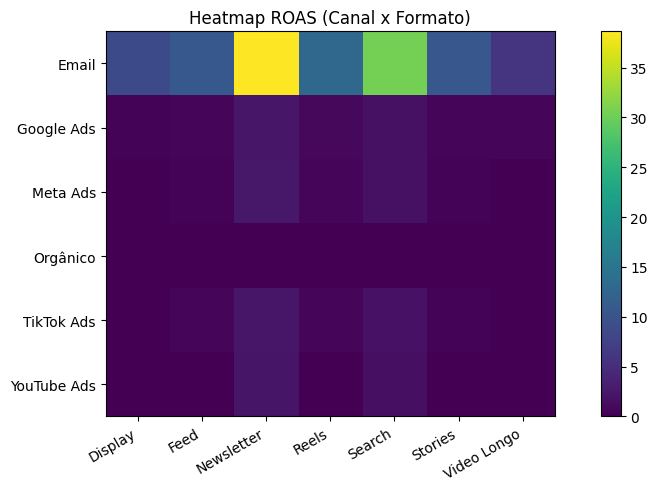

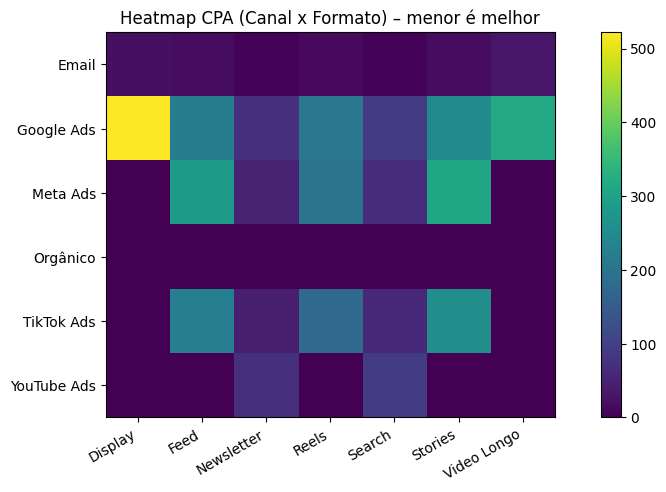

,canal,formato,impressoes,cliques,conversoes,custo,receita,CTR,CPC,CPA,ROAS
2,Email,Newsletter,358638,19544,724,3187.77,123156.50,0.054495,0.163107,4.402997,38.634061
4,Email,Search,392688,19942,594,3518.09,107332.55,0.050783,0.176416,5.922710,30.508756
3,Email,Reels,410685,20155,297,4228.83,54743.87,0.049077,0.209815,14.238485,12.945394
1,Email,Feed,392803,18056,247,4254.34,45503.68,0.045967,0.235619,17.224049,10.695826
5,Email,Stories,321754,15268,194,3351.29,34944.71,0.047452,0.219498,17.274691,10.427241
0,Email,Display,392536,16579,140,2942.18,25337.71,0.042236,0.177464,21.015571,8.611883
6,Email,Video Longo,358309,16000,172,5413.48,32297.57,0.044654,0.338342,31.473721,5.966138
16,Meta Ads,Newsletter,430370,9449,293,15075.21,36476.67,0.021956,1.595429,51.451229,2.419646
30,TikTok Ads,Newsletter,260874,6499,194,8631.20,20391.50,0.024912,1.328081,44.490722,2.362534
9,Google Ads,Newsletter,398846,12370,414,29469.19,68532.35,0.031014,2.382311,71.181618,2.325559


In [9]:
# Filtra combos com volume mínimo (mais confiável para decisão).
combo_f = combo[(combo["cliques"] >= 300) & (combo["conversoes"] >= 30)].copy()

# Cria pivots para heatmap.
pivot_roas = combo_f.pivot(index="canal", columns="formato", values="ROAS").fillna(0)
pivot_cpa  = combo_f.pivot(index="canal", columns="formato", values="CPA").replace([np.inf, -np.inf], 0).fillna(0)

# Heatmap de ROAS usando imshow (sem seaborn).
plt.figure(figsize=(12, 5))                     # Define tamanho da figura.
plt.imshow(pivot_roas.values)                   # Desenha matriz como imagem.
plt.title("Heatmap ROAS (Canal x Formato)")     # Título.
plt.xticks(range(len(pivot_roas.columns)),      # Nomes das colunas no eixo X.
           pivot_roas.columns, rotation=30, ha="right")
plt.yticks(range(len(pivot_roas.index)),        # Nomes das linhas no eixo Y.
           pivot_roas.index)
plt.colorbar()                                  # Barra de escala de cores.
plt.show()                                      # Exibe o gráfico.

# Heatmap de CPA.
plt.figure(figsize=(12, 5))
plt.imshow(pivot_cpa.values)
plt.title("Heatmap CPA (Canal x Formato) – menor é melhor")
plt.xticks(range(len(pivot_cpa.columns)), pivot_cpa.columns, rotation=30, ha="right")
plt.yticks(range(len(pivot_cpa.index)), pivot_cpa.index)
plt.colorbar()
plt.show()

# Exibe os melhores combos por ROAS (com filtro).
combo_f.sort_values("ROAS", ascending=False).head(10)


## 5) Tendência semanal (ROAS e CPA):

Agora vamos observar se a performance está:
- melhorando,
- piorando,
- ou oscilando.

Isso ajuda a justificar otimizações contínuas (ex.: realocar budget, ajustar criativos, revisar segmentação).


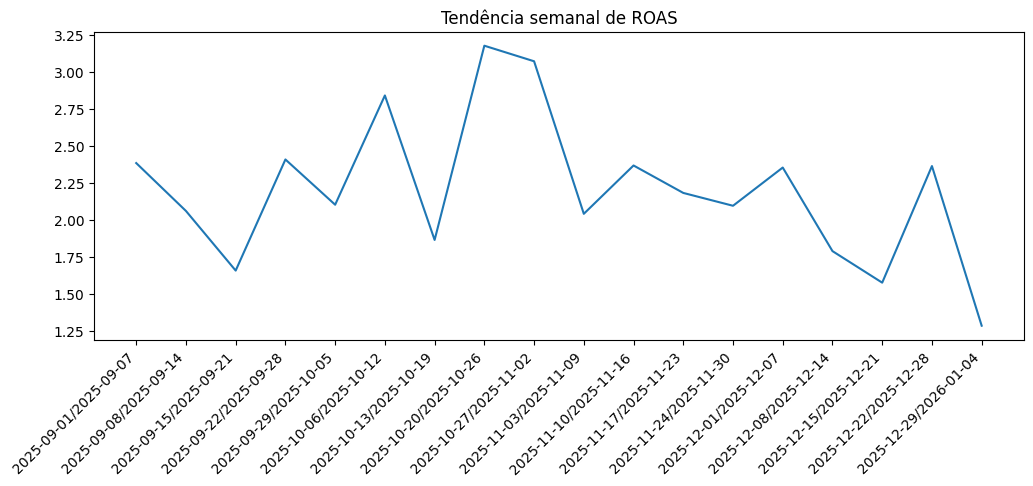

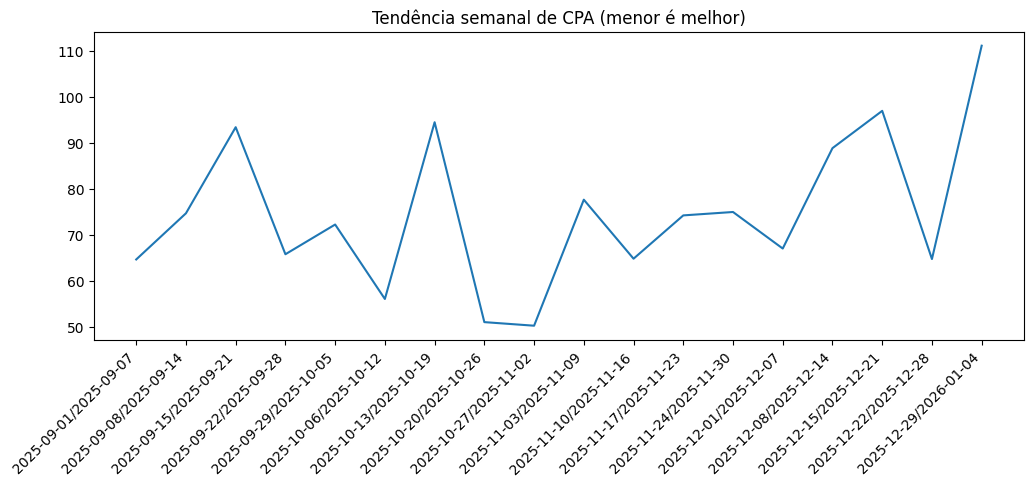

/tmp/ipython-input-3686567510.py:7: RuntimeWarning: divide by zero encountered in divide
  return np.where(b == 0, 0, a / b)


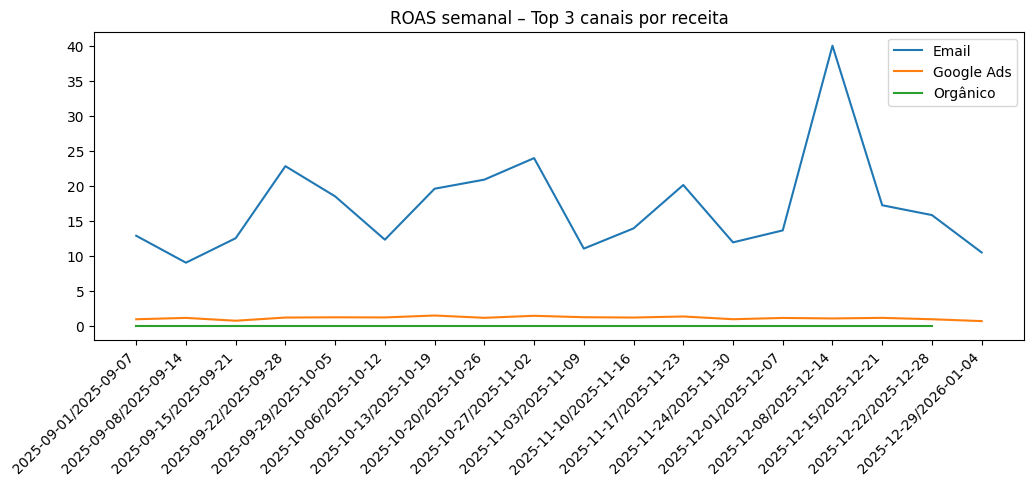

In [10]:
# Cria coluna semanal (período semanal).
df["semana"] = df["data"].dt.to_period("W").astype(str)

# Agrega por semana somando volumes.
semana = df.groupby("semana")[kpis_base].sum().reset_index()

# Calcula KPIs semanais sobre os totais.
semana["CPA"] = safe_div(semana["custo"], semana["conversoes"])
semana["ROAS"] = safe_div(semana["receita"], semana["custo"])

# Gráfico de ROAS semanal.
plt.figure(figsize=(12, 4))
plt.plot(semana["semana"], semana["ROAS"])       # Linha de ROAS.
plt.title("Tendência semanal de ROAS")           # Título.
plt.xticks(rotation=45, ha="right")              # Rotaciona labels para caber.
plt.show()

# Gráfico de CPA semanal.
plt.figure(figsize=(12, 4))
plt.plot(semana["semana"], semana["CPA"])        # Linha de CPA.
plt.title("Tendência semanal de CPA (menor é melhor)")
plt.xticks(rotation=45, ha="right")
plt.show()

# Seleciona Top 3 canais por receita para análise detalhada.
top_canais = (
    df.groupby("canal")["receita"]
      .sum()
      .sort_values(ascending=False)
      .head(3)
      .index
      .tolist()
)

# Filtra dados desses canais.
df_top = df[df["canal"].isin(top_canais)].copy()

# Agrega por semana e canal.
semana_canal = df_top.groupby(["semana","canal"])[kpis_base].sum().reset_index()

# Calcula ROAS semanal por canal.
semana_canal["ROAS"] = safe_div(semana_canal["receita"], semana_canal["custo"])

# Plota ROAS semanal para os top 3 canais.
plt.figure(figsize=(12, 4))
for c in top_canais:
    s = semana_canal[semana_canal["canal"] == c]
    plt.plot(s["semana"], s["ROAS"], label=c)
plt.title("ROAS semanal – Top 3 canais por receita")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()


## 6) Pareto (80/20) de receita por combo:

Pareto te ajuda a responder:
> “Em quantos combos (canal|formato) eu devo focar para capturar ~80% da receita?”

Isso é ótimo para priorização e para justificar foco de otimização.


Combos necessários para ~80% da receita: 15 de 42 (35.7%)


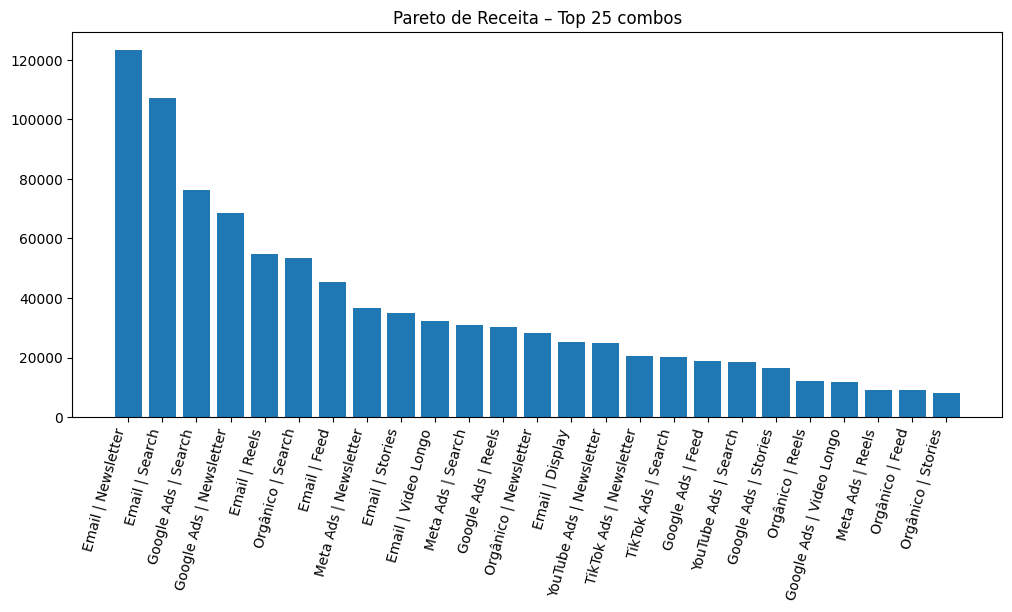

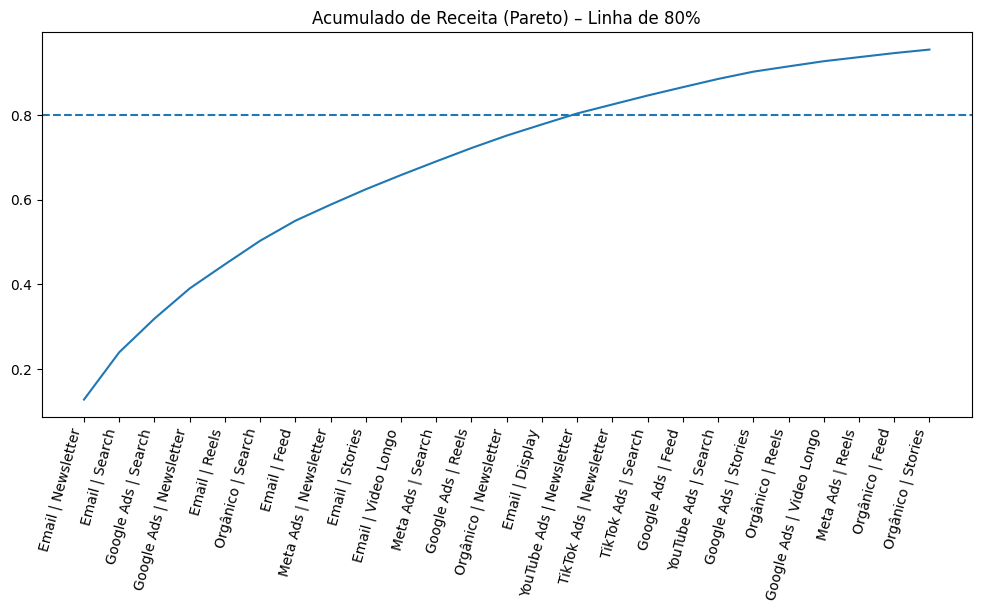

In [11]:
# Copia a tabela de combos.
pareto = combo.copy()

# Cria uma coluna com o nome do combo (canal | formato).
pareto["combo"] = pareto["canal"] + " | " + pareto["formato"]

# Ordena pela receita (maior para menor).
pareto = pareto.sort_values("receita", ascending=False).reset_index(drop=True)

# Receita acumulada.
pareto["receita_acum"] = pareto["receita"].cumsum()

# Percentual acumulado da receita.
pareto["pct_receita_acum"] = safe_div(pareto["receita_acum"], pareto["receita"].sum())

# Calcula quantos combos fazem 80% da receita.
qtd_80 = int((pareto["pct_receita_acum"] <= 0.8).sum() + 1)
qtd_total = len(pareto)

# Mostra o número e a proporção.
print(f"Combos necessários para ~80% da receita: {qtd_80} de {qtd_total} ({qtd_80/qtd_total:.1%})")

# Define top N para visualizar no gráfico.
top_n = 25
p = pareto.head(top_n).copy()

# Gráfico de barras (receita por combo).
plt.figure(figsize=(12, 5))
plt.bar(range(len(p)), p["receita"])
plt.title(f"Pareto de Receita – Top {top_n} combos")
plt.xticks(range(len(p)), p["combo"], rotation=75, ha="right")
plt.show()

# Gráfico do acumulado (linha).
plt.figure(figsize=(12, 5))
plt.plot(range(len(p)), p["pct_receita_acum"])
plt.axhline(0.8, linestyle="--")  # linha de referência em 80%.
plt.title("Acumulado de Receita (Pareto) – Linha de 80%")
plt.xticks(range(len(p)), p["combo"], rotation=75, ha="right")
plt.show()


## 7) Recomendações automáticas (ações sugeridas):

Vamos classificar combos (canal × formato) em:
- **ESCALAR**: ROAS alto + CPA baixo.
- **OTIMIZAR FUNIL**: CTR alto mas CVR baixo (tem clique, mas falta conversão).
- **REDUZIR/PAUSAR**: CPA alto + ROAS fraco.
- **MANTER/TESTAR**: o resto.

As regras são simples, mas comunicam muito bem **como você pensa performance**.


In [12]:
# Trabalha com a base filtrada por volume.
combo_filtrado = combo[(combo["cliques"] >= 300) & (combo["conversoes"] >= 30)].copy()

# Calcula KPIs necessários.
combo_filtrado["CTR"] = safe_div(combo_filtrado["cliques"], combo_filtrado["impressoes"])
combo_filtrado["CPA"] = safe_div(combo_filtrado["custo"], combo_filtrado["conversoes"])
combo_filtrado["ROAS"] = safe_div(combo_filtrado["receita"], combo_filtrado["custo"])

# Percentis para definir "alto" e "baixo" de forma relativa ao seu dataset.
roas_p75 = combo_filtrado["ROAS"].quantile(0.75)                   # top 25% ROAS.
cpa_p25  = combo_filtrado["CPA"].replace(0, np.nan).quantile(0.25) # bottom 25% CPA (ignorando zeros).
ctr_p75  = combo_filtrado["CTR"].quantile(0.75)                    # top 25% CTR.

# CVR (conversão por clique) para detectar gargalo de funil.
cvr = safe_div(combo_filtrado["conversoes"], combo_filtrado["cliques"])
cvr_p25 = np.nanpercentile(cvr, 25)                                # bottom 25% CVR.

# Função que atribui uma ação por linha.
def classificar(row):
    # CVR do combo (conversões / cliques).
    cvr_row = 0 if row["cliques"] == 0 else row["conversoes"] / row["cliques"]

    # ESCALAR: ROAS alto e CPA baixo.
    if row["ROAS"] >= roas_p75 and row["CPA"] > 0 and row["CPA"] <= cpa_p25:
        return "ESCALAR"

    # OTIMIZAR FUNIL: CTR alto (atrai clique), mas CVR baixo (não converte).
    if row["CTR"] >= ctr_p75 and cvr_row <= cvr_p25:
        return "OTIMIZAR FUNIL"

    # REDUZIR/PAUSAR: ROAS abaixo da mediana e CPA acima da mediana.
    if row["ROAS"] < combo_filtrado["ROAS"].median() and row["CPA"] > combo_filtrado["CPA"].replace(0, np.nan).median():
        return "REDUZIR/PAUSAR"

    # Caso contrário, manter e testar.
    return "MANTER/TESTAR"

# Aplica a classificação.
combo_filtrado["acao"] = combo_filtrado.apply(classificar, axis=1)

# Separa os grupos para exibição.
top_escalar  = combo_filtrado[combo_filtrado["acao"] == "ESCALAR"].sort_values("ROAS", ascending=False).head(8)
top_otimizar = combo_filtrado[combo_filtrado["acao"] == "OTIMIZAR FUNIL"].sort_values("CTR", ascending=False).head(8)
top_cortar   = combo_filtrado[combo_filtrado["acao"] == "REDUZIR/PAUSAR"].sort_values("CPA", ascending=False).head(8)

print("=== Recomendações: ESCALAR ===")
display(top_escalar[["canal","formato","cliques","conversoes","custo","receita","CPA","ROAS"]])

print("\n=== Recomendações: OTIMIZAR FUNIL ===")
display(top_otimizar[["canal","formato","cliques","conversoes","CTR","CPA","ROAS"]])

print("\n=== Recomendações: REDUZIR/PAUSAR ===")
display(top_cortar[["canal","formato","cliques","conversoes","custo","receita","CPA","ROAS"]])


=== Recomendações: ESCALAR ===


/tmp/ipython-input-3686567510.py:7: RuntimeWarning: divide by zero encountered in divide
  return np.where(b == 0, 0, a / b)


,canal,formato,cliques,conversoes,custo,receita,CPA,ROAS
2,Email,Newsletter,19544,724,3187.77,123156.50,4.402997,38.634061
4,Email,Search,19942,594,3518.09,107332.55,5.922710,30.508756
3,Email,Reels,20155,297,4228.83,54743.87,14.238485,12.945394
1,Email,Feed,18056,247,4254.34,45503.68,17.224049,10.695826
5,Email,Stories,15268,194,3351.29,34944.71,17.274691,10.427241
0,Email,Display,16579,140,2942.18,25337.71,21.015571,8.611883
6,Email,Video Longo,16000,172,5413.48,32297.57,31.473721,5.966138



=== Recomendações: OTIMIZAR FUNIL ===


,canal,formato,cliques,conversoes,CTR,CPA,ROAS



=== Recomendações: REDUZIR/PAUSAR ===


,canal,formato,cliques,conversoes,custo,receita,CPA,ROAS
7,Google Ads,Display,10080,47,24526.91,7524.81,521.849149,0.306798
13,Google Ads,Video Longo,9558,72,22633.57,11712.76,314.355139,0.517495
19,Meta Ads,Stories,7355,37,11435.22,4566.65,309.060000,0.399350
15,Meta Ads,Feed,5884,33,9354.57,4137.90,283.471818,0.442340
33,TikTok Ads,Stories,6399,32,8260.52,3327.81,258.141250,0.402857
12,Google Ads,Stories,10313,101,25125.59,16513.24,248.768218,0.657228
29,TikTok Ads,Feed,5609,32,7204.52,3565.09,225.141250,0.494841
8,Google Ads,Feed,10654,117,25535.23,18992.39,218.249829,0.743772
